# PRiAD 4 - test zaliczający

Test obejmuje materiał z ćwiczenia PRiAD4, wymaga także znajmości zagadnień z wcześniejszych ćwiczeń.

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

> **Zadanie 1** Wykonaj grupowanie danych zbioru `iris` metodą aglomeracyjną. Oszacuj na podstawie analizy otrzymanych danych (m.in. dendrogramu) jakia jest optymalna liczba grup i najlepszy typ odległości.

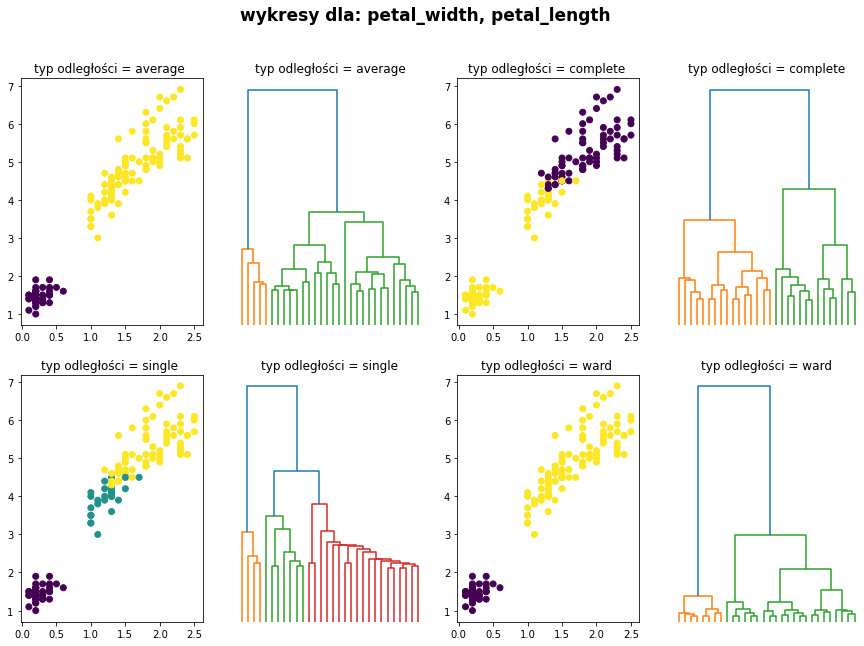

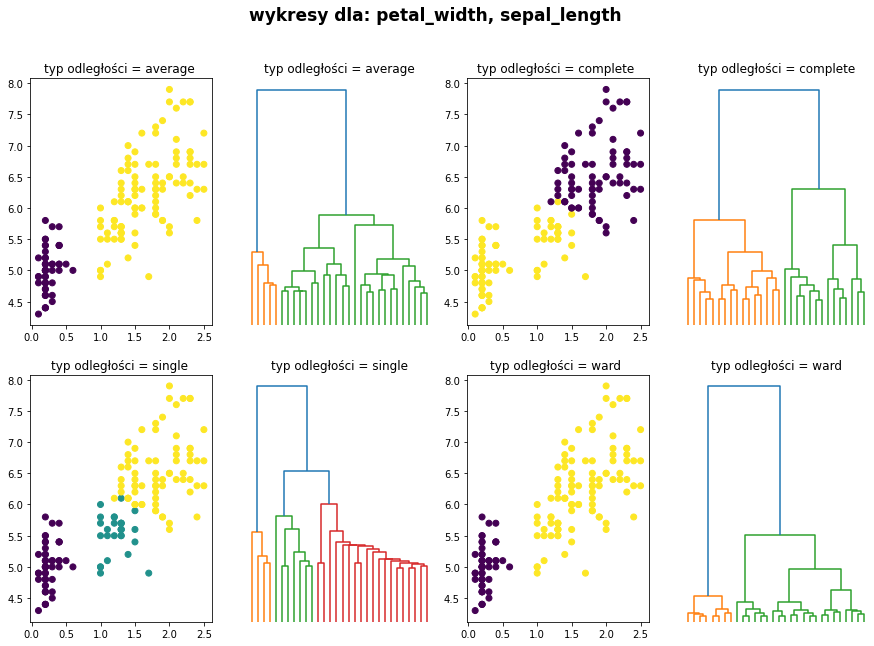

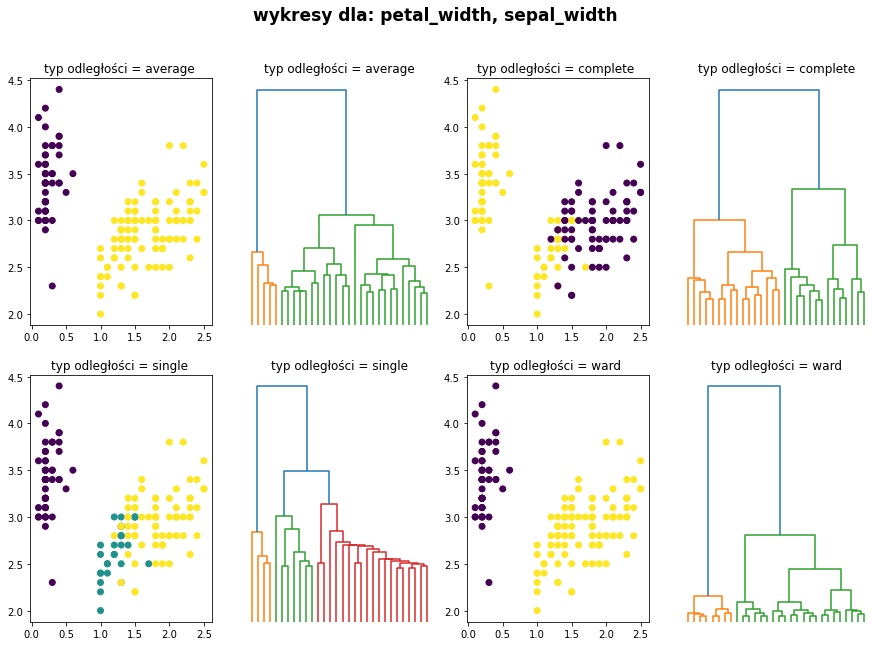

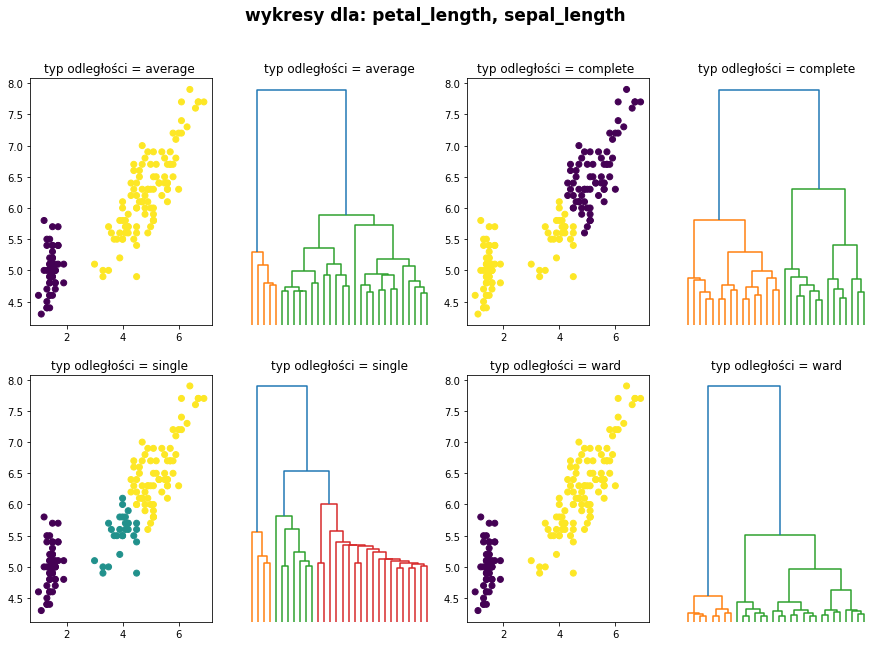

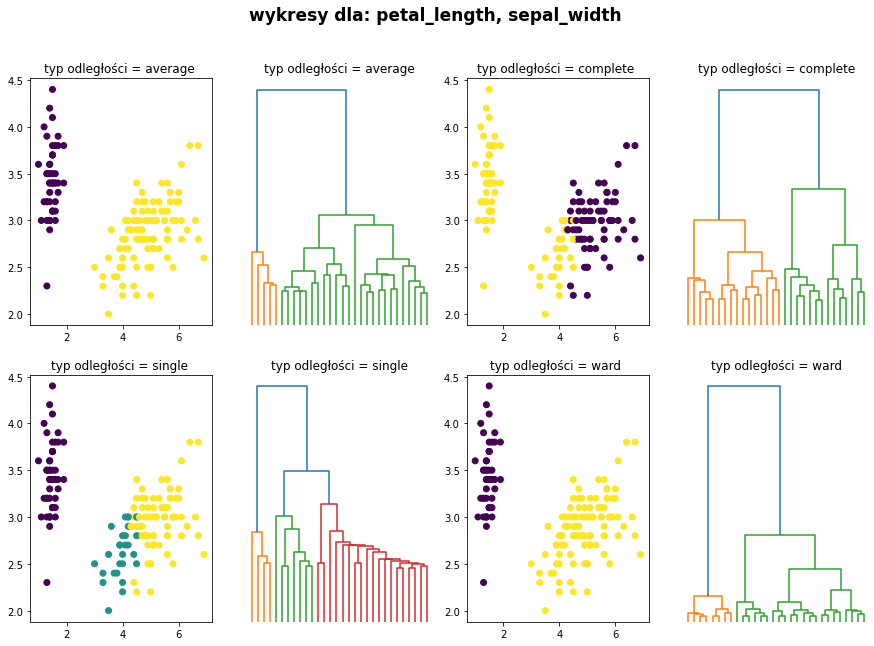

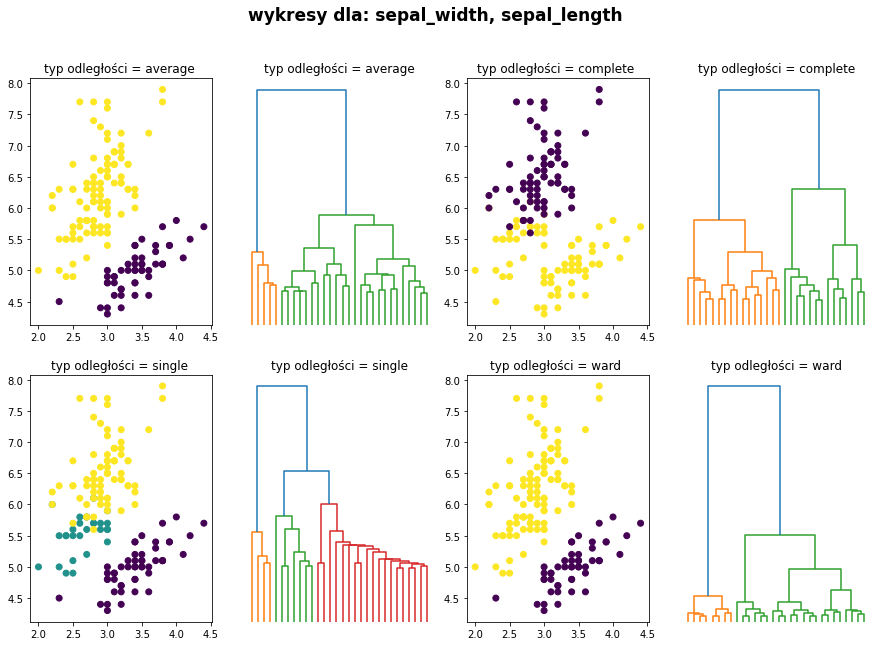

In [53]:
df_org = pd.read_csv('iris.csv', index_col = 0)
df = df_org.drop(columns = ['species'])

def wykres(atrybut1, atrybut2):
    wy = plt.figure(figsize=(15, 10))
    for i, typ_odleglosci in enumerate(('average', 'complete', 'single', 'ward')):                                      
        grupy = linkage(df, method = typ_odleglosci, metric = 'euclidean')
        prog_proc = 60
        prog = prog_proc*max(grupy[:,2])/100            
        df['grupa'] = fcluster(grupy, prog, criterion = 'distance')
        
        wy = plt.subplot(2, 4, 1 + 2*i)
        wy.set_title('typ odległości = %s ' % typ_odleglosci)
        plt.scatter(x = df[atrybut1], y = df[atrybut2], c = df['grupa'])
        wy = plt.subplot(2, 4, 2 + 2*i)        
        plt.axis('off')
        plt.suptitle('wykresy dla: %s, %s' % (atrybut1, atrybut2), size = 17, fontweight = 'bold')
        wy.set_title('typ odległości = %s' % typ_odleglosci)
        d = dendrogram(grupy, truncate_mode = 'lastp', color_threshold = prog)  

wykres('petal_width', 'petal_length')
wykres('petal_width', 'sepal_length')
wykres('petal_width', 'sepal_width')
wykres('petal_length', 'sepal_length')
wykres('petal_length', 'sepal_width')
wykres('sepal_width', 'sepal_length')



Wnioski z analizy wyników zad. 1:
* Liczba grup wyznaczana jest u mnie automatycznie. Dla metody single jest to 3, zaś dla average, complete i ward 2 ( dla progu 60%) Wiemy, że dla naszego zbioru liczba grup to 3, metoda single daje ten wynik.
* Dla wszystkich zależności( sepal_width i sepal_length, petal_width i sepal_width itd.) wykresy punktowe dla average i ward są identyczne(mają dwa skupiska obiektów- żółte i fioletowe). Mimo że wykresy dla single i complete mają identyczne rozmieszczanie punktów jak pozostałe wykresy, to różnią się kolarami skupisk. Dla single z żółtego skupiska został wyodrębniony oddzielny morski( w zestawieniu z ward  i average)- czyli single ma 3 skupiska obiektów. Dla wykresu complete (posiadającego dwa skupiska obiektów- żółte i fioletowe) w zestawieniu z ward  i average wszystkie punkty fioletowe stały się żółte, a część żółtych stała się fioletowa ( ta część która nie uległa zmianie jest w wykresie single oznaczona kolorem morskim).
* więkoszość naszych wykresów punktowych wskazuje na dwa gatunki kwiatów, ponieważ wyodrębniają dwa skupiska(sytuacja dotyczy ward i average). W complete możemy doszukiwać się wyodrębnionych 3 skupisk, jednak to single najdokładniej pokazuje wyodrębione 3 skupiska.
* dendogramy dla average i ward pokazują podział na 3 skupiska ( z wyraźną dominacją ilościową jednego z nich). Dendogram dla complete pokazuje podział na 3 skupiska w tym 2 są mniej więcej równe. Dla single widzimy podział na 4 skupiska, w tym 3 wyraźnie wyszczególnione- czyli tak jak jest w rzeczywistości
* Najoptymalnieszą liczbą grup jest 3, ponieważ większość naszych wykresów tak wskazuje ( 50% na 3, 37,5% na 2 i 12,5% na 4)
* z naszej analizy wynika, że dla progu 60% najlepszą metodą jest metoda single, ponieważ zarówno wykres punktowy jak i dendogram wskazują podział na 3 grupy, czyli tak jak jest w rzeczywistości. 

> **Zadanie 2** Napisz funkcję, która będzie wizualizować metodę sylwetki i łokciową dla dowolnego zbioru danych (z dowolną liczba atrybutów opisujących). Pierwszym argumentem tej funkcji powinien być zbiór (ramka) danych, drugim - zakres zmian k, trzecim - nazwy dwóch atrybutów wyświetlanych na wykresie punktowym obok wykresu sylwetki. 

In [56]:
def wizualizuj(dane, zakres, atrybuty):
    grupy = list(range(2, zakres+1))
    d = pd.Series(dtype = 'float64')
    
    for k in grupy:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)
        
        ax1.set_xlim([-0.2, 1])
        ax1.set_ylim([0, len(dane) + (k + 1) * 10])
    
        kmeans = KMeans(n_clusters=k, random_state=0).fit(dane)
        d = d.append(pd.Series(kmeans.inertia_))
        etykiety = kmeans.fit_predict(dane[[atrybuty[0], atrybuty[1]]])  
 
        sylwetka = silhouette_samples(dane[[atrybuty[0], atrybuty[1]]], etykiety)   
        srednia_sylwetka = silhouette_score(dane[[atrybuty[0], atrybuty[1]]], etykiety)
    
        pozycja_kreski = 10
        for i in range(k):
            sylwetka_w_grupie = sylwetka[etykiety == i]
            sylwetka_w_grupie.sort()

            liczebnosc_grupy = sylwetka_w_grupie.shape[0]
            kolor = cm.tab10(float(i) / k)
            ax1.fill_betweenx(np.arange(pozycja_kreski, pozycja_kreski + liczebnosc_grupy), 0, sylwetka_w_grupie ,color = kolor)

            pozycja_kreski += liczebnosc_grupy + 10
        
        ax1.set_title("Wykres sylwetek dla poszczególnych liczb grup")
        ax1.set_xlabel("Wartość sylwetek")
        ax1.set_ylabel("Etykiety grup")

        ax1.axvline(x = srednia_sylwetka, color = "black", linestyle = "--")
        ax1.set_yticks([]) 
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        kolory = cm.tab10(etykiety.astype(float) / k)
        ax2.scatter(dane[atrybuty[0]],dane[atrybuty[1]], marker = '.', s = 30, lw = 0, alpha = 0.7,c = kolory)

        ax2.set_title("Wizualizacja grupowania danych")
        ax2.set_xlabel(atrybuty[0])
        ax2.set_ylabel(atrybuty[1])

        plt.suptitle(("Analiza sylwetki k = %d" % k),  fontweight = 'bold')
        plt.figtext(0.14, 0, ("Dla n = %d, średnia wartość sylwetki wynosi: %.3f, suma odległości od centroidów: %.2f"
                 % (k, srednia_sylwetka, kmeans.inertia_ ) ))
        plt.show()
    
    plt.plot(grupy, d,'bo-')
    plt.title("Wykres łokciowy", fontsize = 14, fontweight = 'bold')
    plt.xlabel("Liczba grup")
    plt.ylabel("Suma odległości od centroidów")

   atrybut1   atrybut2  etykieta
0 -6.923242 -10.669532         2
1 -8.630620  -7.139406         2
2 -9.630481  -2.720449         1
3 -2.306477   5.307977         0
4 -7.570054  -3.014465         3


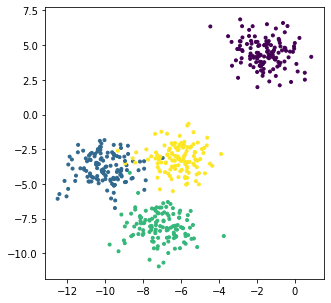

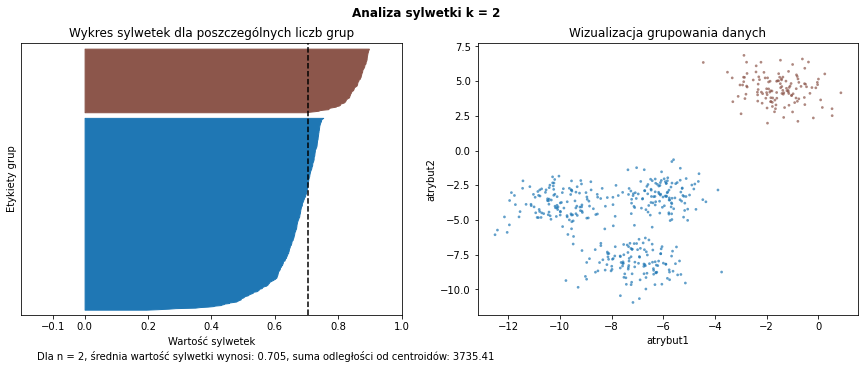

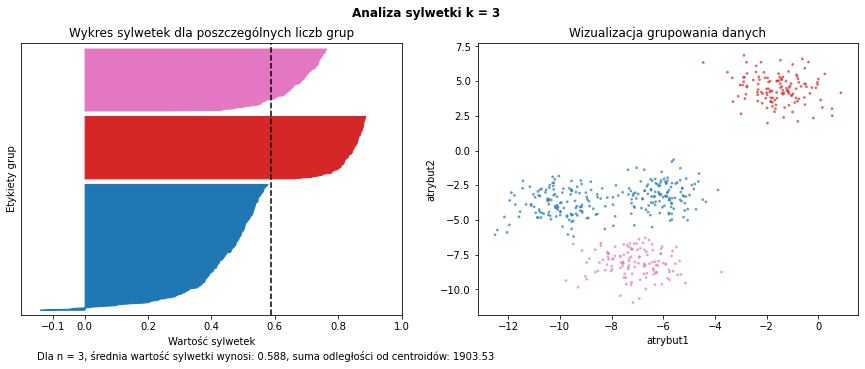

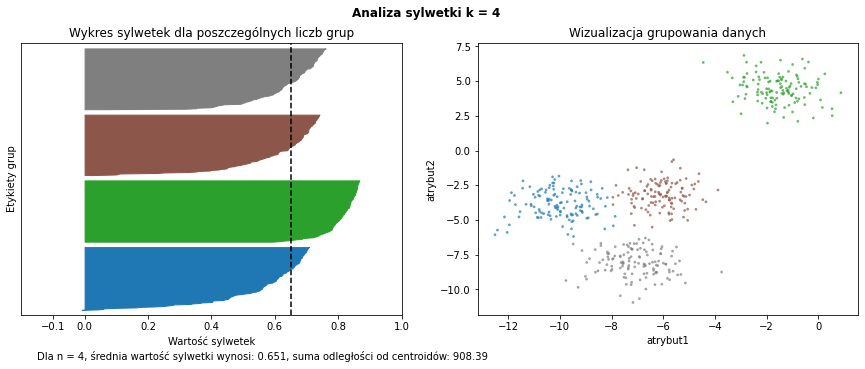

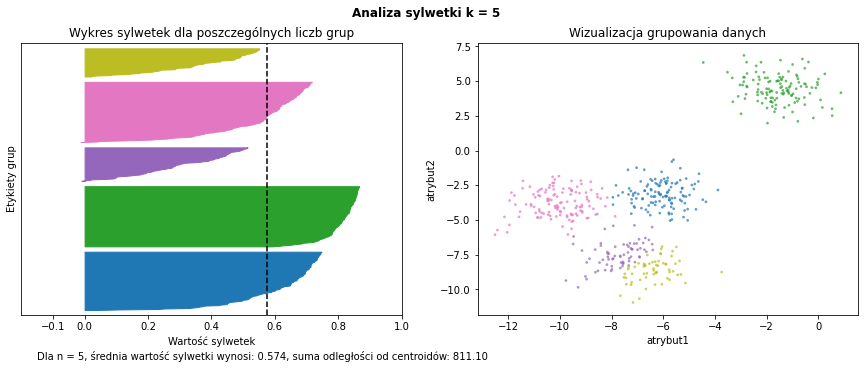

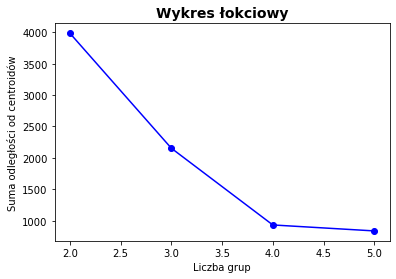

In [57]:
# kod skryptu prezerntującego działanie funkcji
X1, y1 = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, 
                    center_box = (-10.0, 10.0), shuffle = True, random_state = 1)  

columns = ['atrybut' + str(x) for x in np.arange(1, X1.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X1.T)}
d['etykieta'] = y1
dane = pd.DataFrame(d).reindex(columns=columns+['etykieta'])

print(dane.head())
plt.figure(figsize=(5,5))
plt.scatter(dane.atrybut1, dane.atrybut2, marker='.', c=dane.etykieta)

zakres = 5
wizualizuj(dane, zakres, ['atrybut1', 'atrybut2'])


> **Zadanie 3** Wykonaj grupowanie danych zbioru `iris` metodą k-średnich. Określ optymalne paramtery grupowania  (liczbę grup, typ odległości). Określ obiema metodami (łokciową i sylwetki) jakia jest dla optymalna liczba grup.

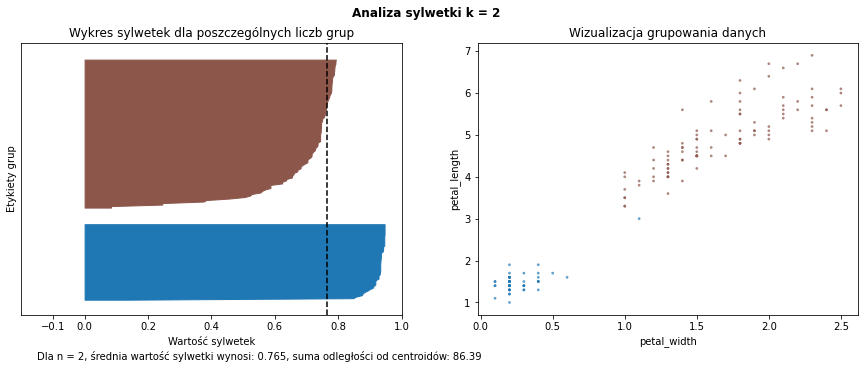

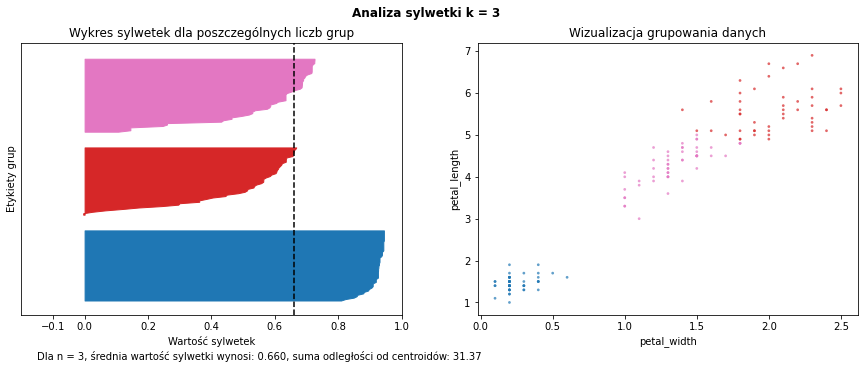

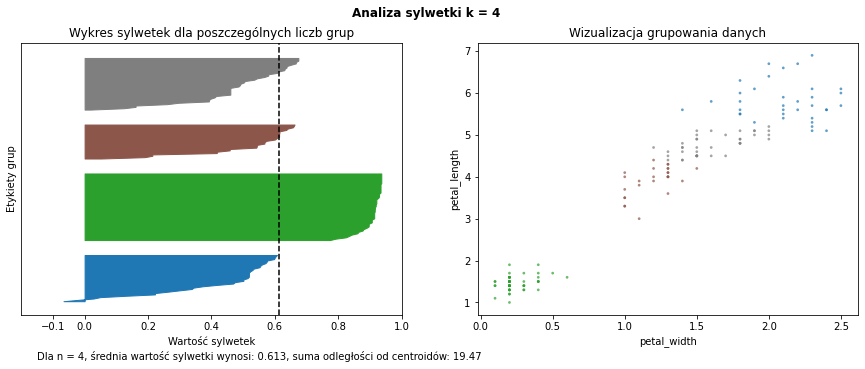

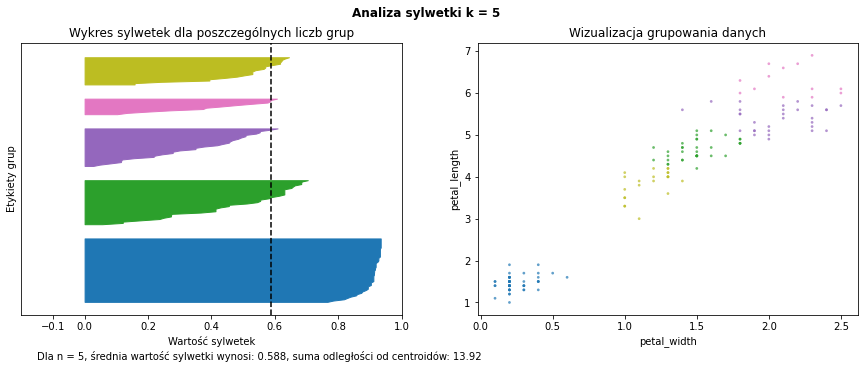

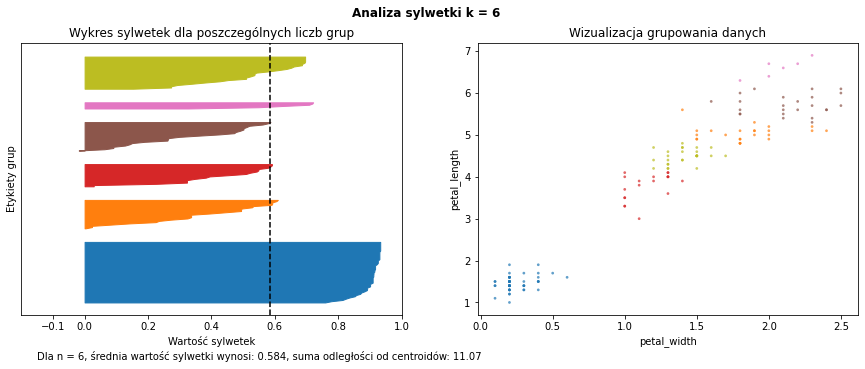

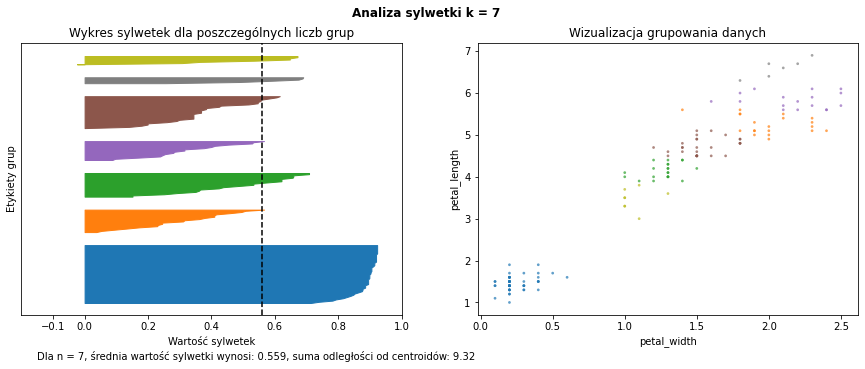

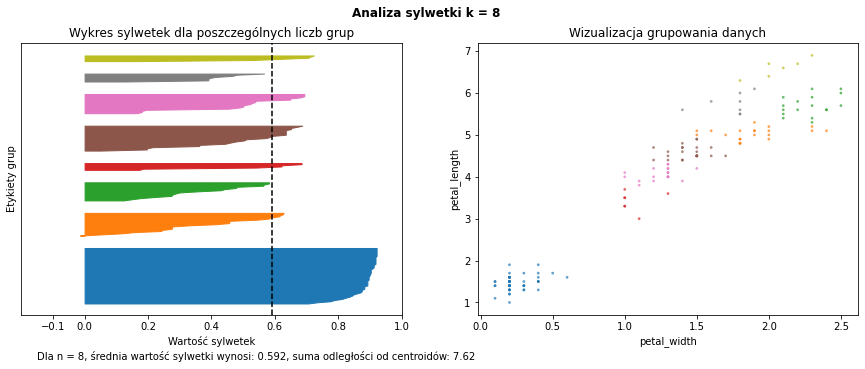

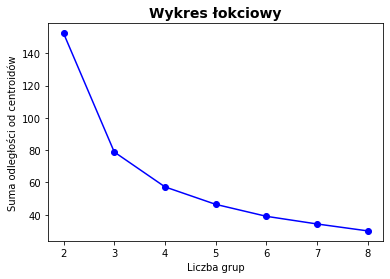

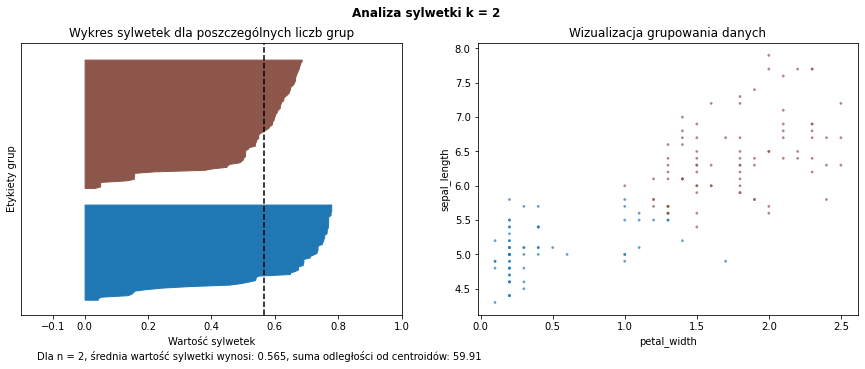

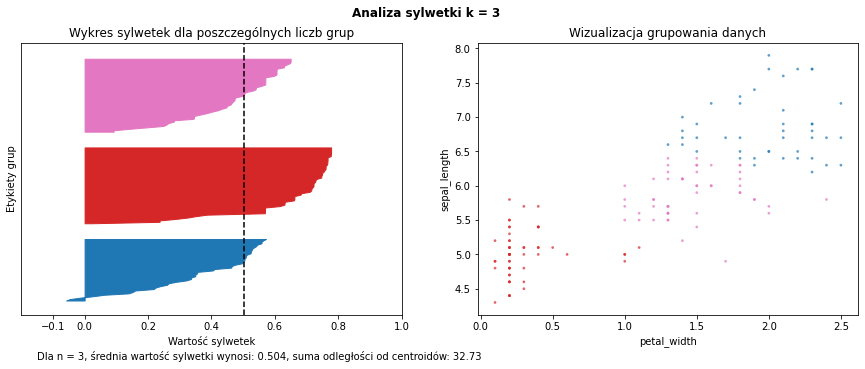

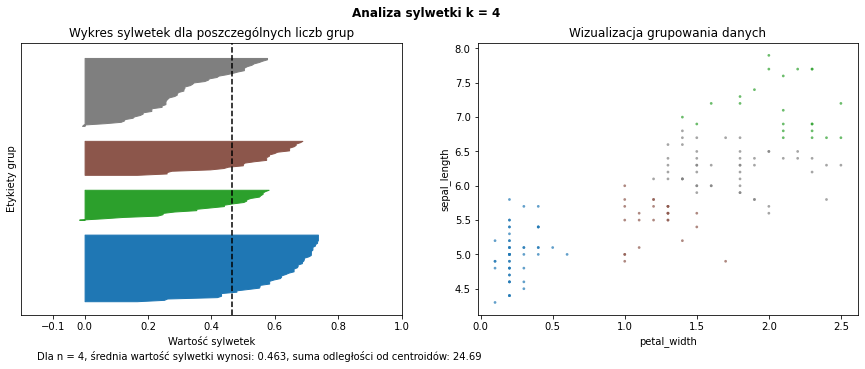

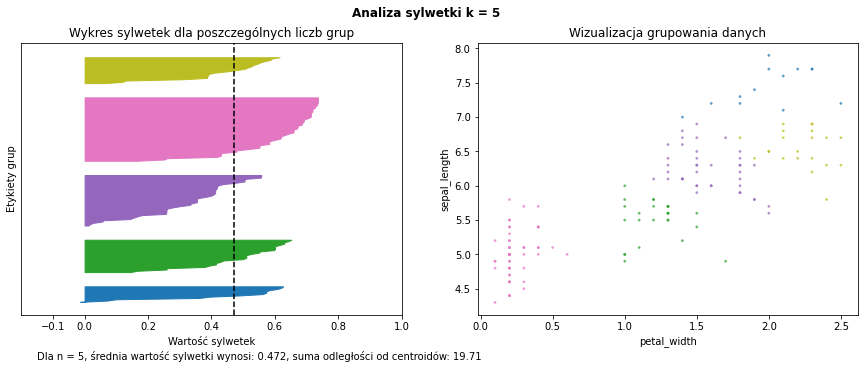

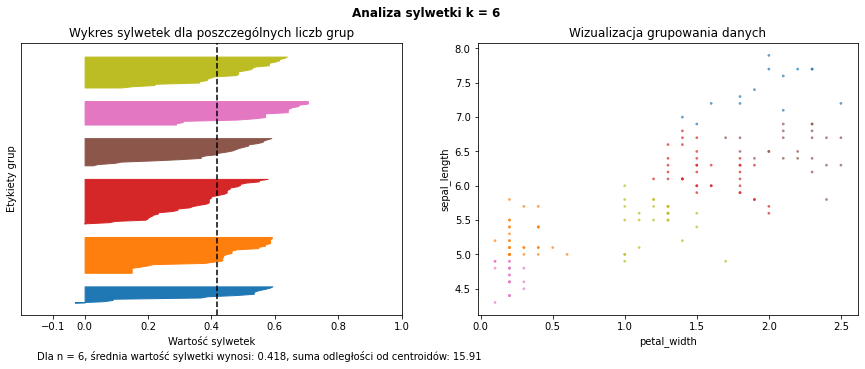

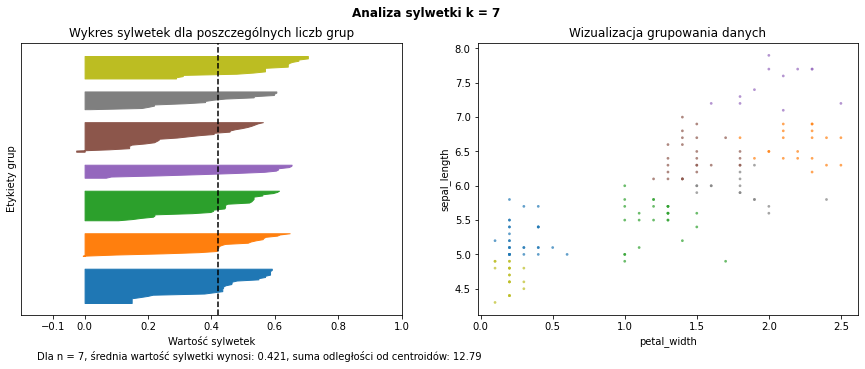

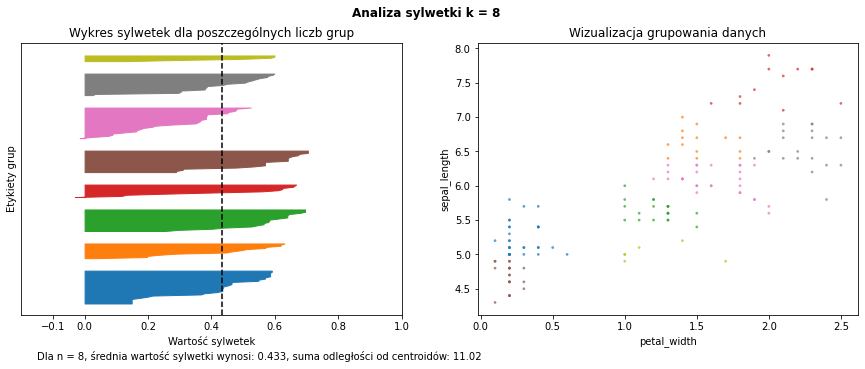

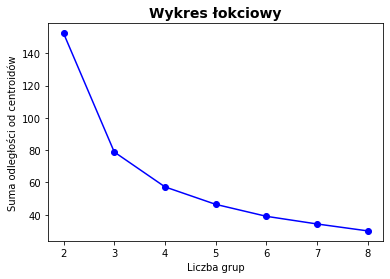

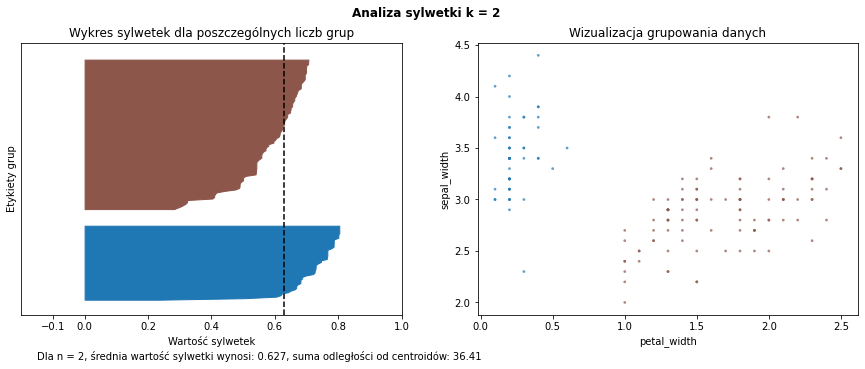

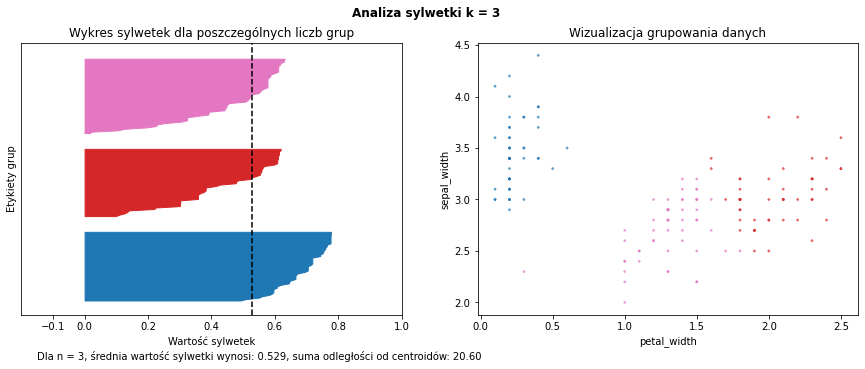

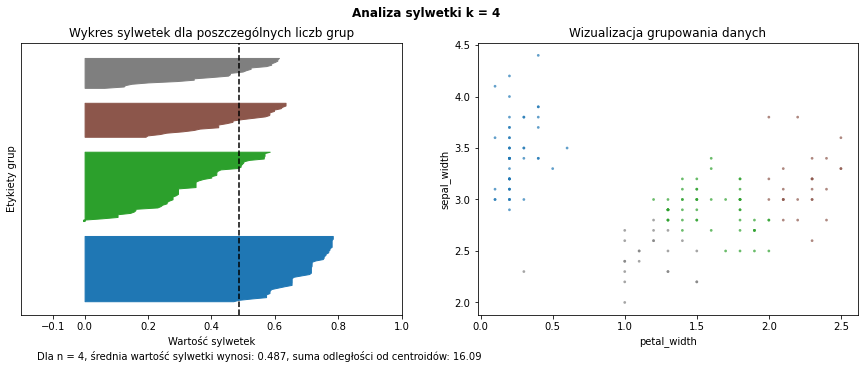

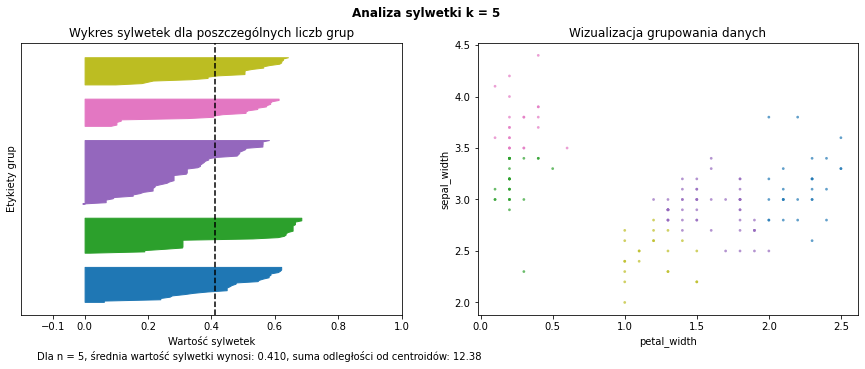

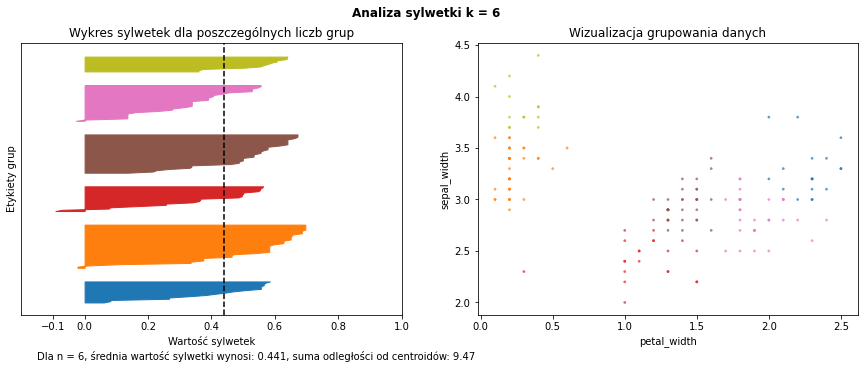

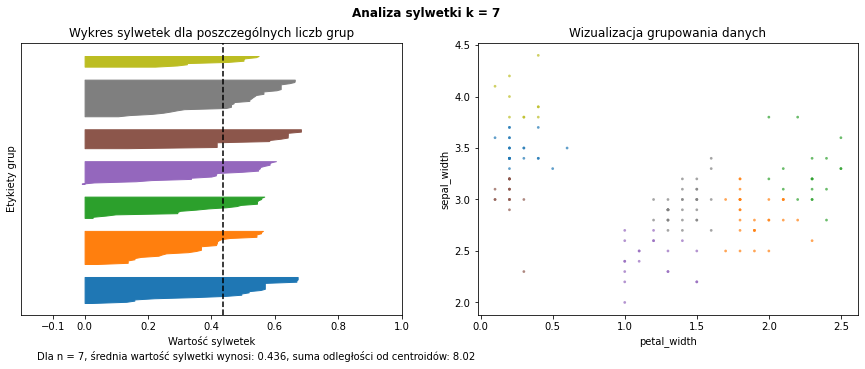

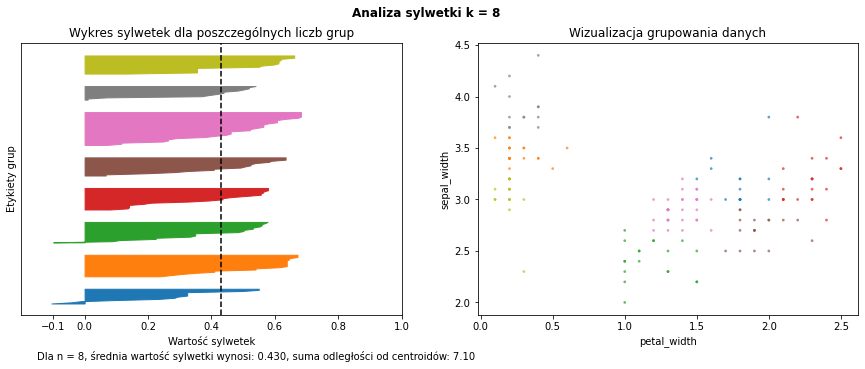

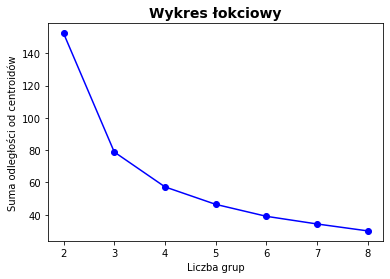

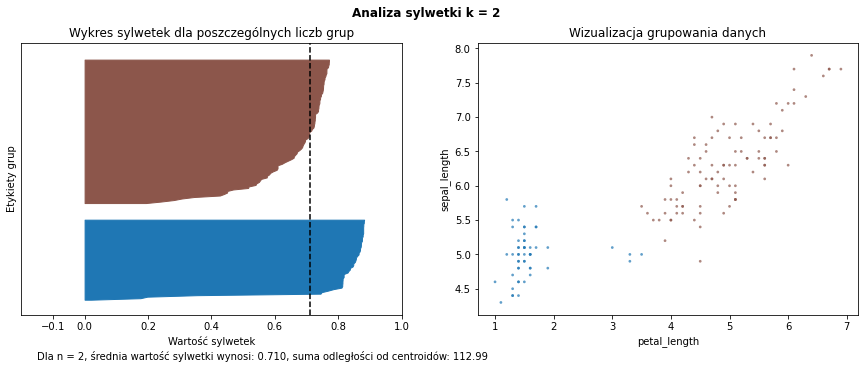

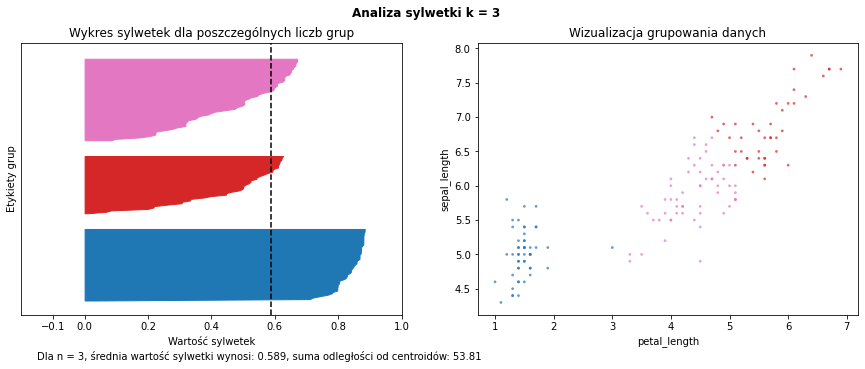

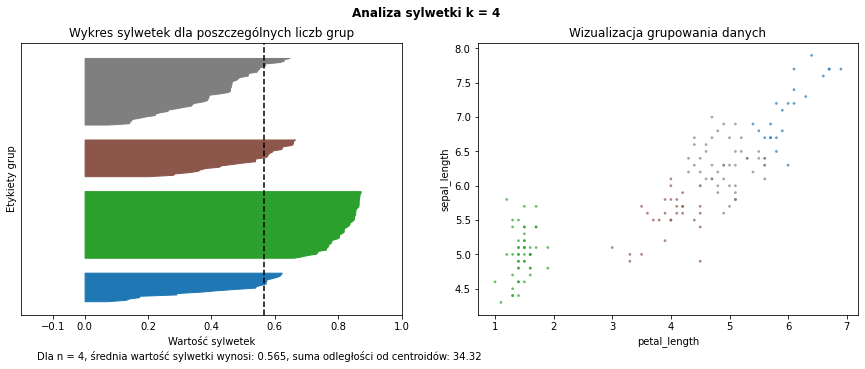

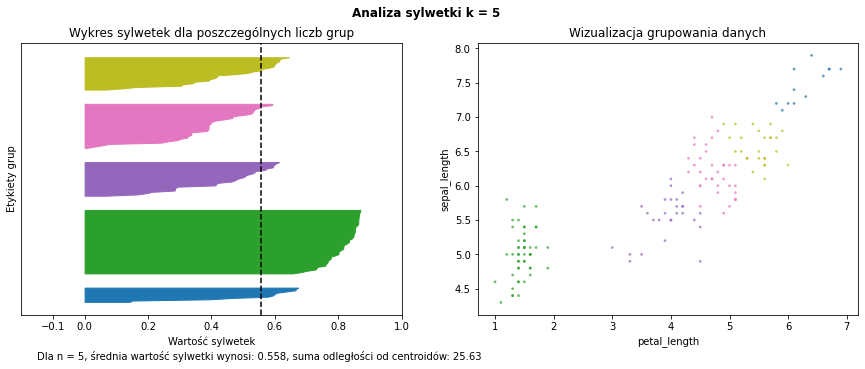

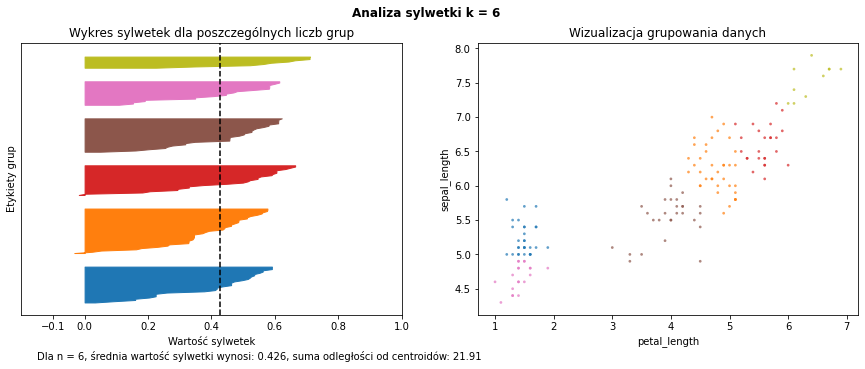

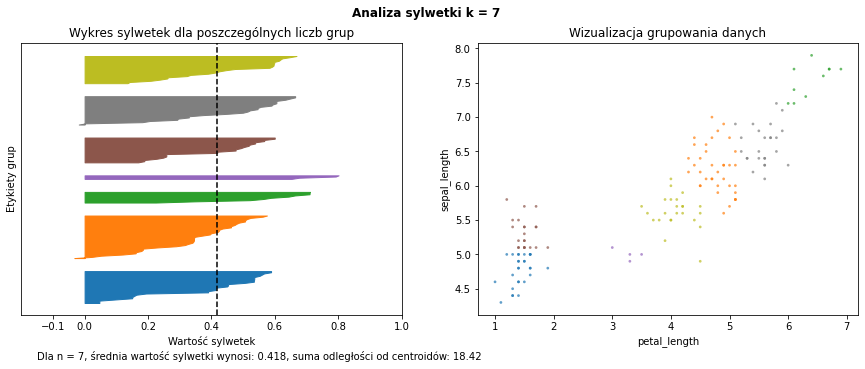

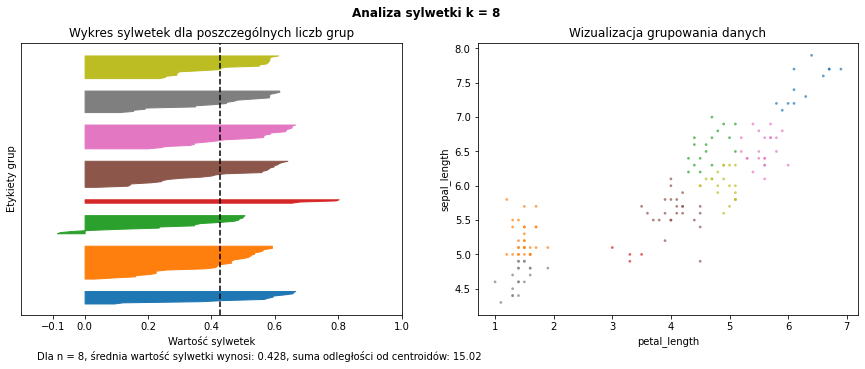

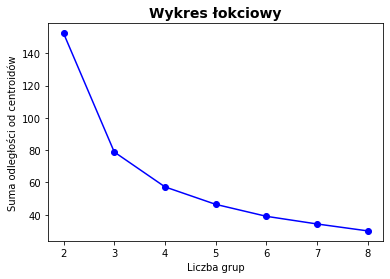

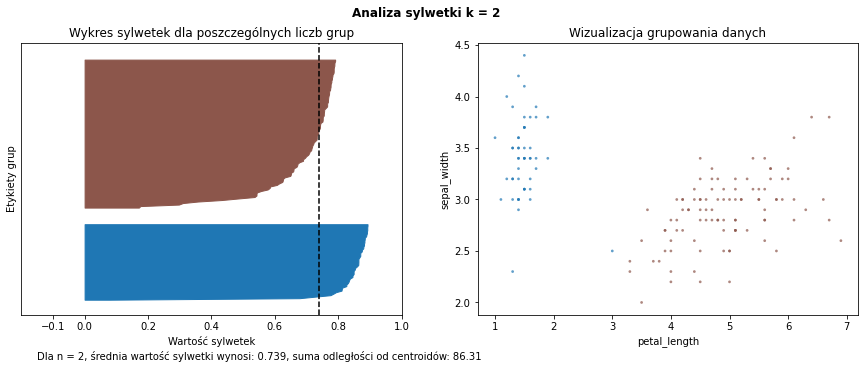

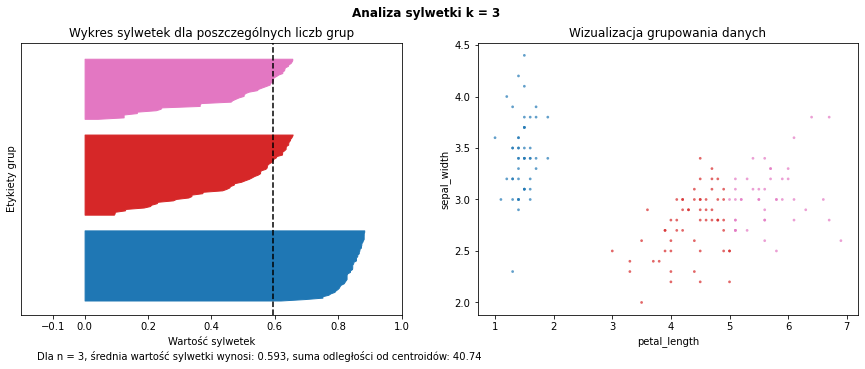

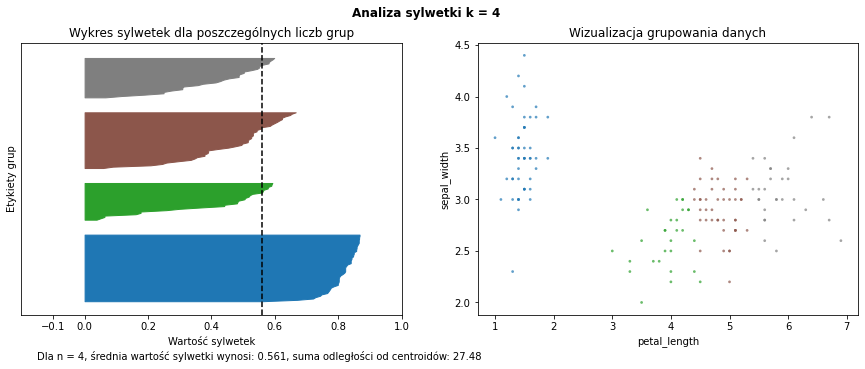

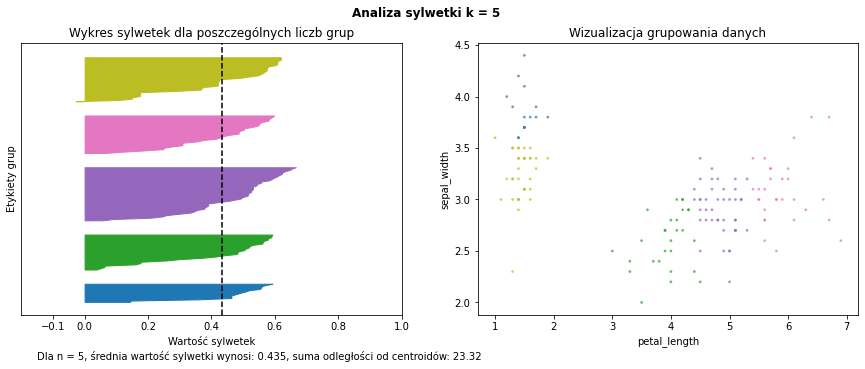

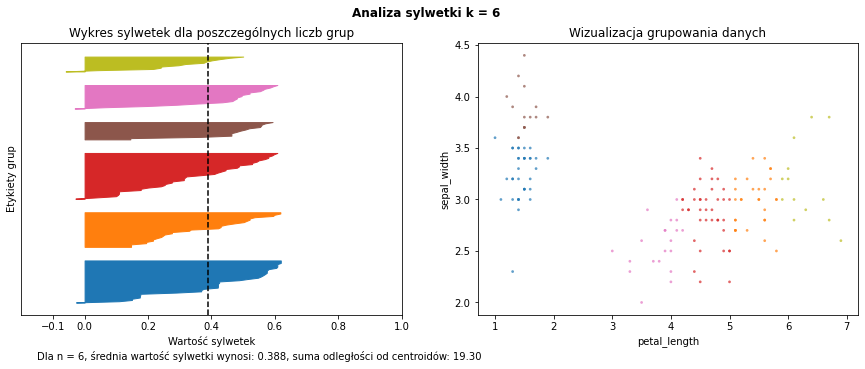

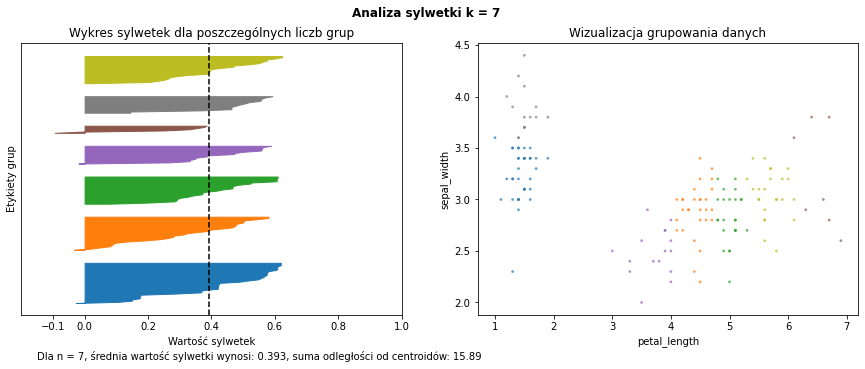

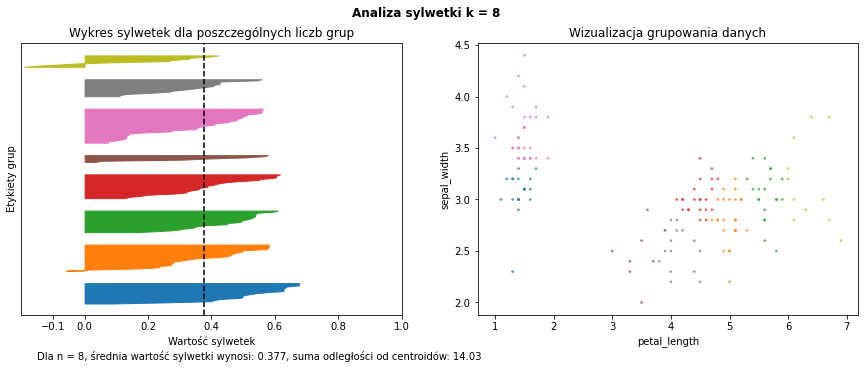

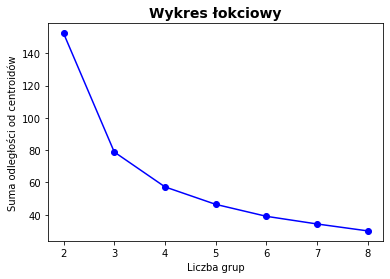

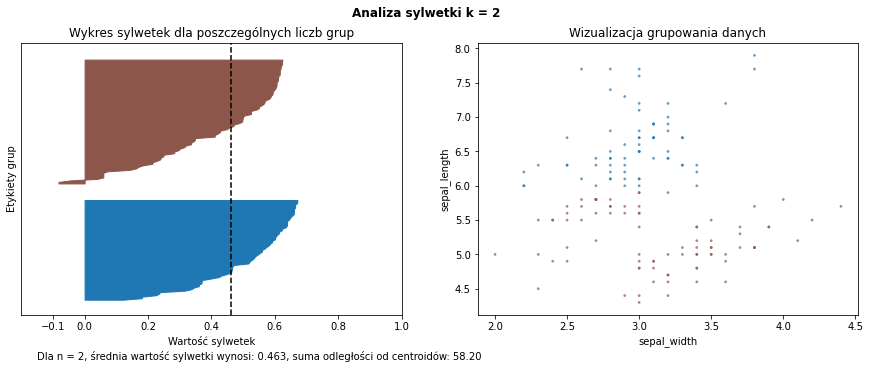

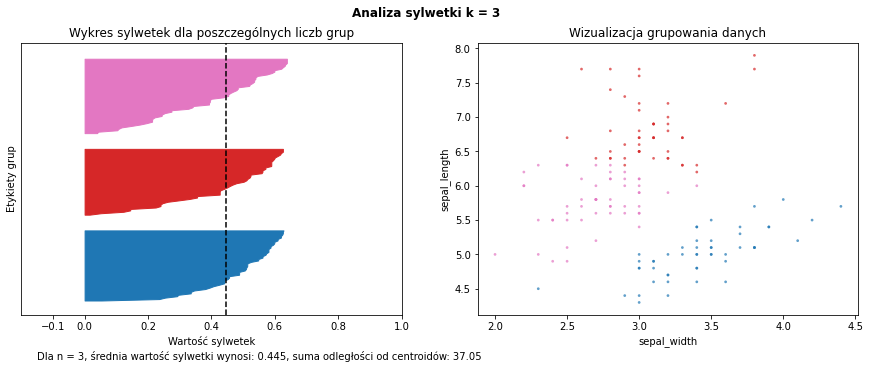

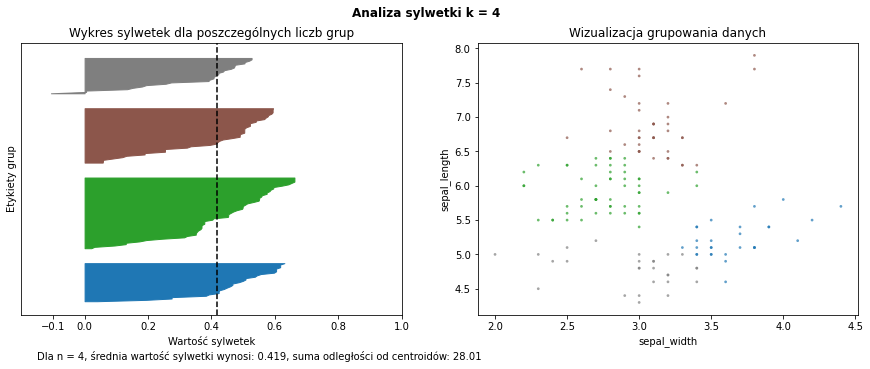

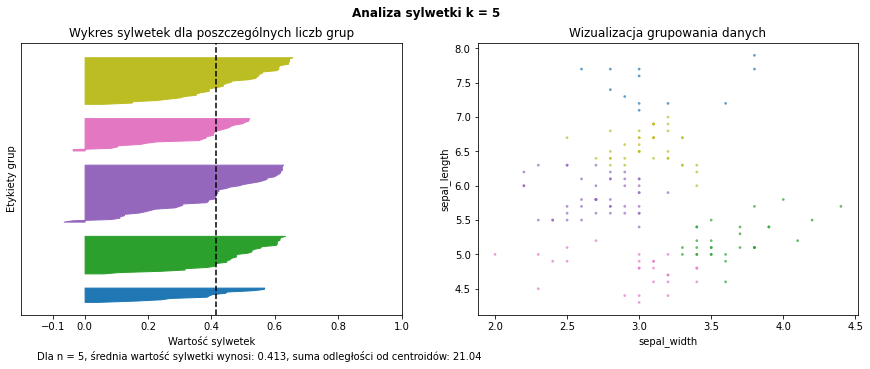

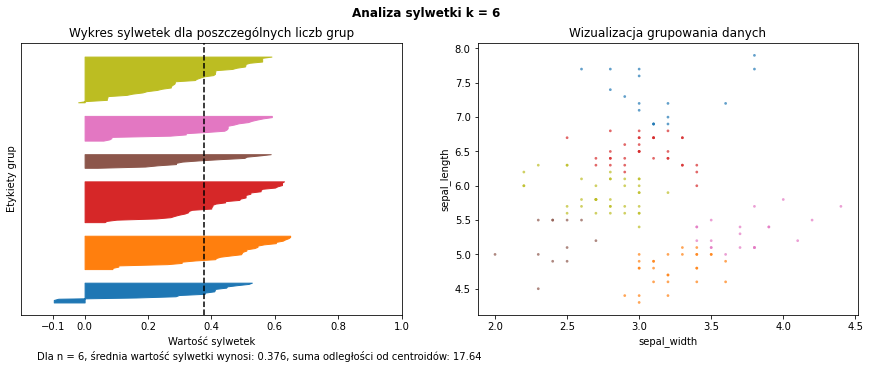

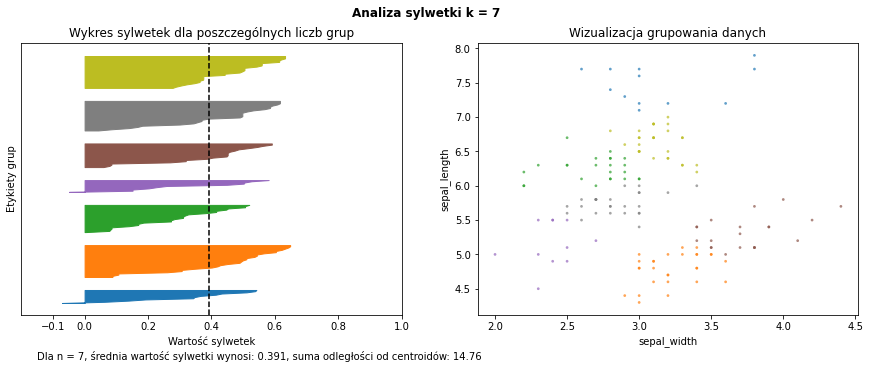

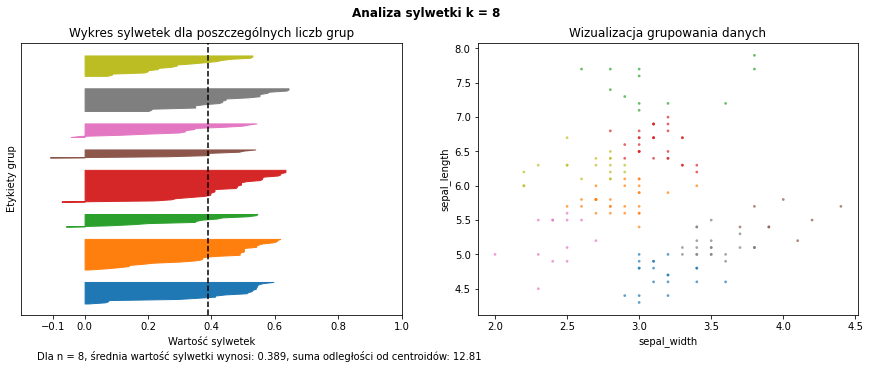

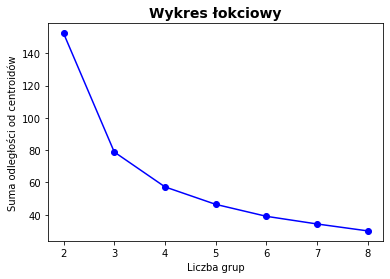

In [58]:
iris_org = pd.read_csv('iris.csv', index_col = 0)
iris = iris_org.drop(columns = ['species'])

zakres = 8
wizualizuj(iris, zakres, ['petal_width', 'petal_length'])
wizualizuj(iris, zakres, ['petal_width', 'sepal_length'])
wizualizuj(iris, zakres, ['petal_width', 'sepal_width'])
wizualizuj(iris, zakres, ['petal_length', 'sepal_length'])
wizualizuj(iris, zakres, ['petal_length', 'sepal_width'])
wizualizuj(iris, zakres, ['sepal_width', 'sepal_length'])


Wnioski z analizy wyników zad. 3:
* dla każdej zależności stworzyłam wykresy sylwetek i wizualizacje grupowania danych dla sylwetek od 2 do 8 i wykres łokciowy dla każdej zależności
* analizując wykresy sylwetek, szukam takiego dla którego wszystkie grupy przekraczają wartość średnią oraz średnia wartość sylwetki jest największa
* w przypadku wykresów zależności petal_width i petal_length dla k>=3 można zauważyć, że przynajmniej jedna z grup (prawie) nie przekracza średniej wartości, natomiast dla wykresów pozostałych zależności dla każdego k grupy przekraczają wartość średnią sylwetki
* analizujać wykresy zależności ( poza pierwszą zależnością) dostrzegam, że dla k = 2 i k = 3 wartość średnia sylwetki jest największa, jednak suma odległości od centroidów dla k =2 jest znacznie większa niż dla k=3, dlatego 3 jest korzystniejsze
* analizując wykres łokciowy zahamowanie spadku następuje dla liczby grup równej 3 (dla każdej zależności)


> **Zadanie 4** Wygeneruj losowo zestaw transakcji w sklepie (15 produktów - "Produkt 1", "Produkt 2"...; 200 transakcji; ramka danych binarnych). Wyznacz dla przyjętych wartości wsparcia i ufności zestaw reguł asocjacyjnych dla tego zbioru.

In [51]:
koszyk = pd.DataFrame(np.random.randint(0,2,size=(200, 15)), columns = ['Produkt{}'.format(x) for x in range(1, 16)])

zbiory_czeste = apriori(koszyk, min_support=0.1, use_colnames=True)
reguly = association_rules(zbiory_czeste, metric="lift", min_threshold=1)

reguly[(reguly['confidence'] >= 0.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1581,"(Produkt7, Produkt14, Produkt2)",(Produkt1),0.150,0.605,0.125,0.833333,1.377410,0.034250,2.370000
1701,"(Produkt14, Produkt10, Produkt2)",(Produkt1),0.125,0.605,0.110,0.880000,1.454545,0.034375,3.291667
1729,"(Produkt11, Produkt14, Produkt2)",(Produkt1),0.115,0.605,0.105,0.913043,1.509163,0.035425,4.542500
1768,"(Produkt5, Produkt3, Produkt8)",(Produkt1),0.125,0.605,0.100,0.800000,1.322314,0.024375,1.975000
1887,"(Produkt14, Produkt3, Produkt8)",(Produkt1),0.135,0.605,0.110,0.814815,1.346801,0.028325,2.133000
2148,"(Produkt5, Produkt10, Produkt13)",(Produkt1),0.125,0.605,0.100,0.800000,1.322314,0.024375,1.975000
2183,"(Produkt14, Produkt10, Produkt7)",(Produkt1),0.130,0.605,0.105,0.807692,1.335029,0.026350,2.054000
2233,"(Produkt10, Produkt13, Produkt8)",(Produkt1),0.145,0.605,0.125,0.862069,1.424907,0.037275,2.863750
2247,"(Produkt14, Produkt10, Produkt8)",(Produkt1),0.130,0.605,0.105,0.807692,1.335029,0.026350,2.054000
2275,"(Produkt9, Produkt10, Produkt13)",(Produkt1),0.130,0.605,0.105,0.807692,1.335029,0.026350,2.054000


> **Zadanie 5** Zmień nazwę tego skryptu na następującą "PRiAD4_Imię_Nazwisko.ipynb" i wgraj wgraj go do ISOD-a we wskazane miejsce, nie przekraczając wyznaczonego terminu.